In [ ]:
#librerie
import os
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn import metrics
import random as rd
from sklearn.svm import SVC
from google.colab import drive
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [ ]:
drive.mount('/content/drive/', force_remount=True)
#GDrivePath = '/content/drive/MyDrive/CV_progetto2'

Mounted at /content/drive/


In [ ]:
# Funzione per leggere le immagini e creare una lista di etichette
def carica_immagini_e_etichette(cartella_principale):
    '''
    per caricare le immagini del dataset e assegnare le relative etichette in base
    al nome della sottocartella in cui sono contenute
    '''
    etichette = []
    immagini = []

    for cartella in os.listdir(cartella_principale):
        cartella_path = os.path.join(cartella_principale, cartella)

        if os.path.isdir(cartella_path):
            for file in os.listdir(cartella_path):
                file_path = os.path.join(cartella_path, file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    try:
                        img = Image.open(file_path)
                        img.verify()

                        # Aggiungi l'immagine e la sua etichetta (nome della cartella)
                        immagini.append(file_path)
                        etichette.append(cartella)
                    except (IOError, SyntaxError):
                        # Se l'immagine non è valida, la ignora
                        continue

    return immagini, etichette


#Punto 1#
build a visual vocabulary:


*   sample many (10K to 100K) SIFT descriptors from the images of
the training set (you either use a detector or sample on a grid in the
scale-space);
*  cluster them using k-means (the choice of the number of clusters is
up to you, and you should experiment with different values, but you
could start with a few dozens);
*  collect (and save for future use) the clusters’ centroids which repre-
sent the k 128-dimensional visual words.

In [ ]:
#carico immagini training
cartella_training = '/content/drive/MyDrive/CV_progetto2/train'
images_training, train_labels  = carica_immagini_e_etichette(cartella_training)

In [ ]:
#trovo le classi
labels = np.unique(train_labels)
print(labels)
n_classes = len(labels)
print(n_classes)

['Bedroom' 'Coast' 'Forest' 'Highway' 'Industrial' 'InsideCity' 'Kitchen'
 'LivingRoom' 'Mountain' 'Office' 'OpenCountry' 'Store' 'Street' 'Suburb'
 'TallBuilding']
15


In [ ]:
#SIFT descriptor
all_descriptors = []
k_p = 1000 #stop 1000
for image_path in images_training:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create(k_p)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        all_descriptors.append(descriptors)
all_descriptors = np.vstack(all_descriptors)

In [ ]:
#funzioni di tuning per le visual_words
k_list = [x for x in range(12,120,12)]
inertia_values = []

fig = figsize=(15, 15)
for k in k_list:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(all_descriptors)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(all_descriptors, kmeans.labels_)
    print("For k = {}\n Mean silhouette_avg = {}" .format(k, score))
    plt.title("Silhouette Plot")
    plt.xlabel("Silhouette Coefficients")
    plt.ylabel("Proposed Cluster Label")
    plt.suptitle(("Silhouette Analysis"
                  "with k = %d" % k),
                 fontsize=14, fontweight='bold')
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(all_descriptors)
    plt.show()

  # Plot inertia values
plt.plot(k_list, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
#Cluster descriptors per visual words (vocabulary)
k = 60 #tuning necessario
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)
visual_words = kmeans.cluster_centers_

#Punto 2#
Represent each image of the training set as a normalized histogram having
k bins, each corresponding to a visual word; possibility is to perform a
rather dense sampling in space and scale; another possibility is to use the
SIFT detector to find the points in scale-space where the descriptor is
computed. In any case, each computed descriptor will increase the value
of the bin corresponding to the closest visual word.

In [ ]:
def compute_histograms(images):
  '''
  per ottenere gli istogrammi per ogni immagine
  '''
  histograms = []
  for image_path in images:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)

    hist = np.zeros(k)
    if descriptors is not None:
        for descriptor in descriptors:
            distances = np.linalg.norm(visual_words - descriptor, axis=1)
            visual_word_index = np.argmin(distances)
            hist[visual_word_index] += 1

    #normalizzo l'istogramma
    hist = hist / np.sum(hist)
    histograms.append(hist)
  return histograms

In [ ]:
def plot_histograms(histograms, title='Histograms'):
  '''
  plotto gli istogrammi per ogni immagine
  '''
  plt.figure(figsize=(10, 6))
  n_histograms = len(histograms)
  width = 0.8/n_histograms
  for idx, hist in enumerate(histograms):
    x_positions = np.arange(len(hist))+ idx*width
    plt.bar(x_positions, hist,width=width, label=f'Image {idx + 1}')
    plt.title('Histograms of Visual Words')
    plt.xlabel('Visual Word Index')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()


In [ ]:
train_histograms = compute_histograms(images_training)

#Punto 3#

Employ a nearest neighbor classifier and evaluate its performance:


*   compute the normalized histogram for the test image to be classified;
*   assign to the image the class corresponding to the training image
having the closest histogram.
*   repeat for all the test images and build a confusion matrix.

In [ ]:
#Carico le immagini di test
cartella_test = '/content/drive/MyDrive/CV_progetto2/test'
images_test, test_labels  = carica_immagini_e_etichette(cartella_test)

In [ ]:
test_histograms = compute_histograms(images_test)

In [ ]:
#label encoding training_labels text-numbers
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(train_labels)

In [ ]:
#shuffle data
indices = list(range(len(train_labels)))
rd.shuffle(indices)
train_histograms = [train_histograms[i] for i in indices]
labels_train_encoded = [labels_train_encoded[i] for i in indices]
indices_test = list(range(len(test_labels)))
rd.shuffle(indices_test)
test_histograms = [test_histograms[i] for i in indices_test]
test_labels = [test_labels[i] for i in indices_test]

3
5
7
9
11
13
15
17
19


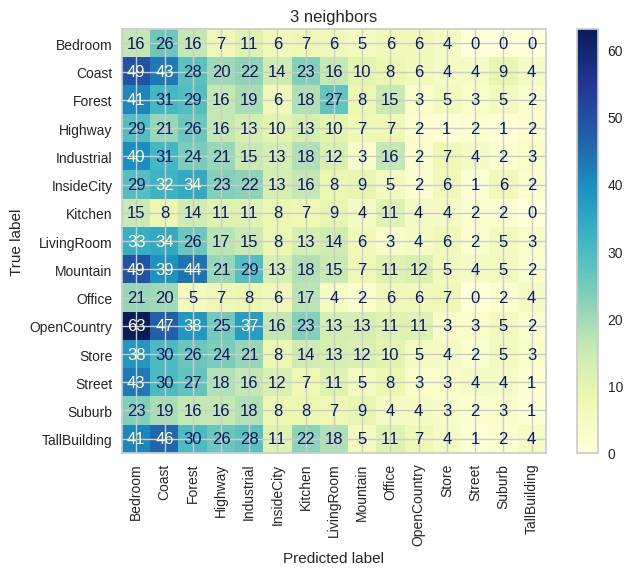

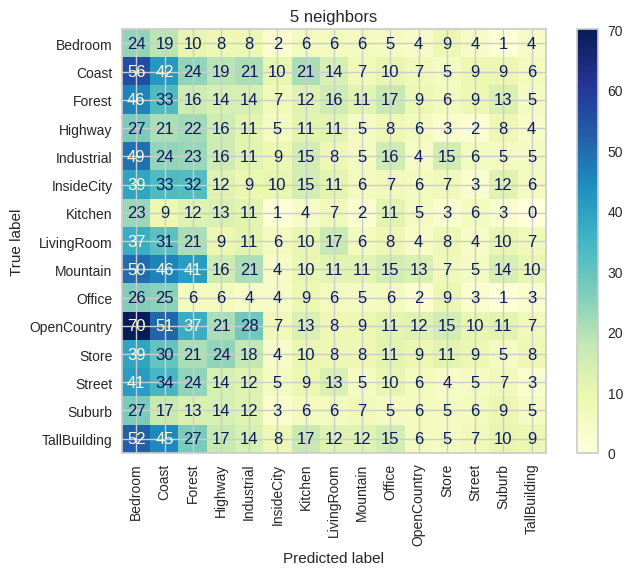

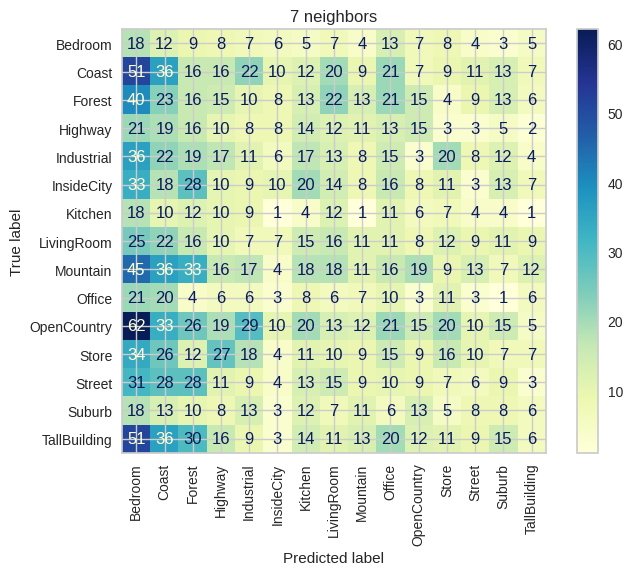

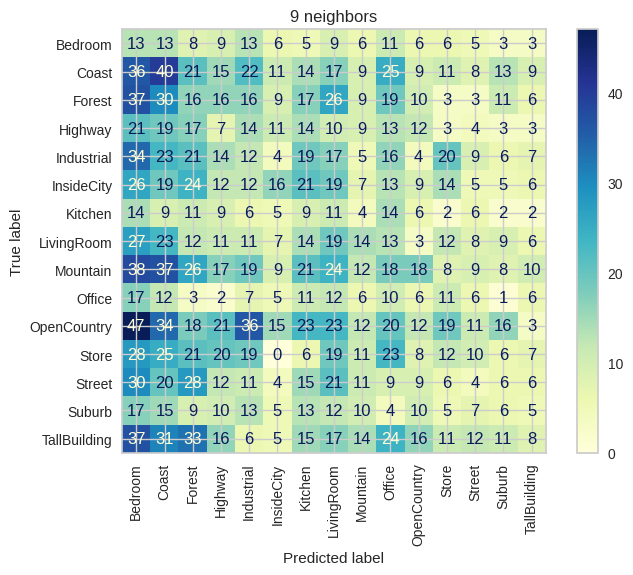

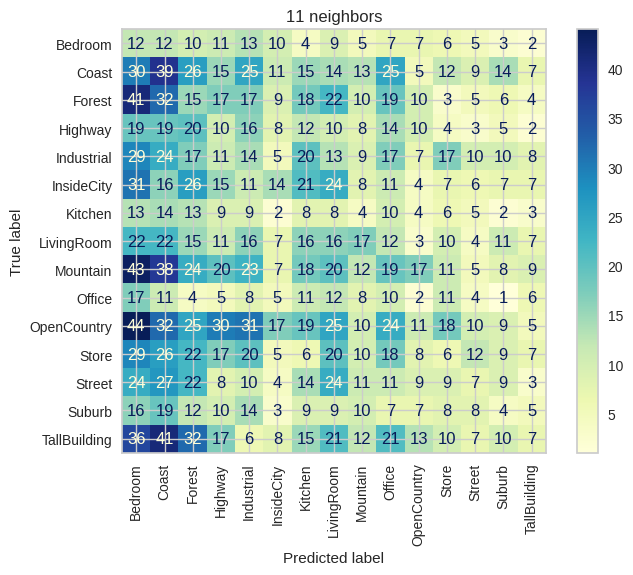

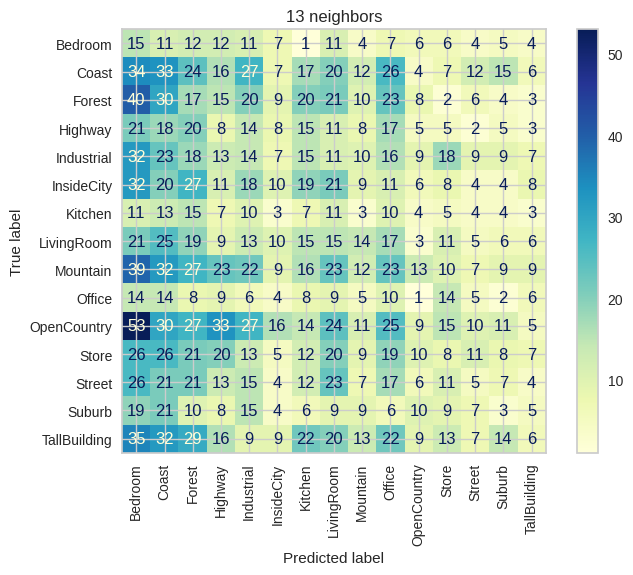

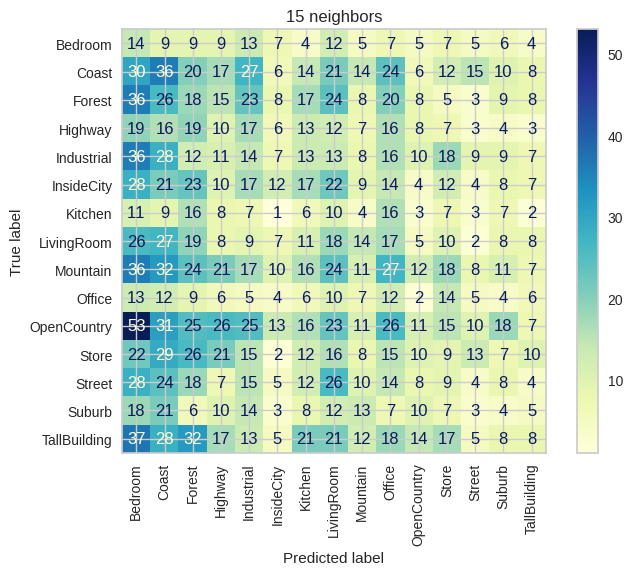

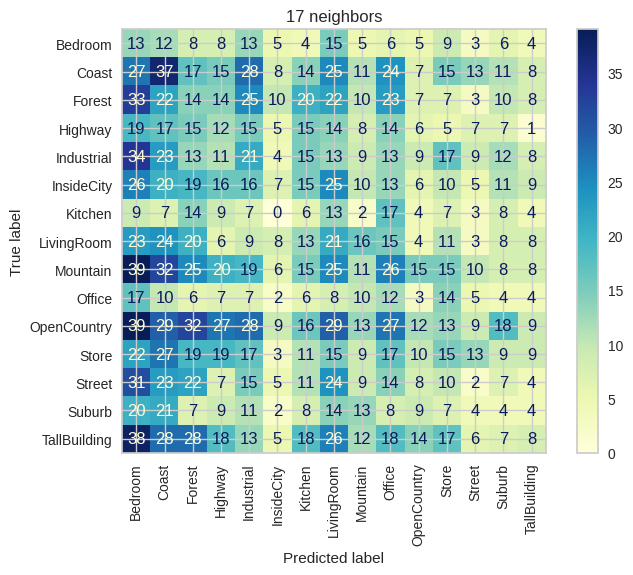

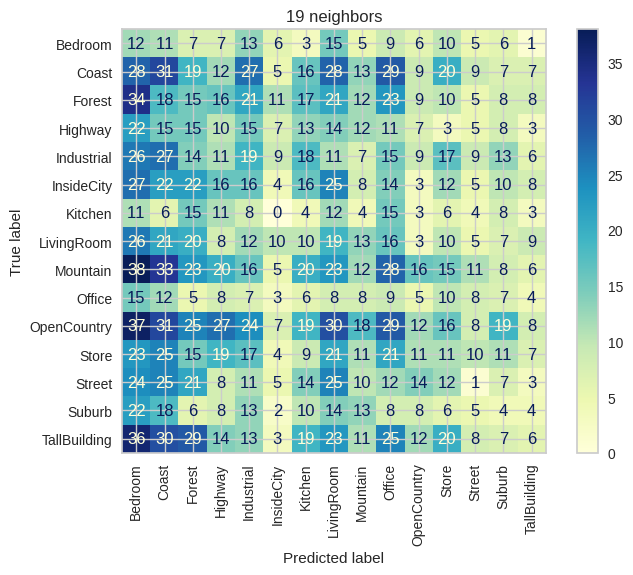

In [ ]:
for k in range(3,20,2):
#training
  neigh = KNeighborsClassifier(n_neighbors=k) #mikownski distance ppuoi farlo anche con altre
  neigh.fit(train_histograms, labels_train_encoded)
#test phase
  predicted_labels = neigh.predict(test_histograms)
# confusion matrix
  predicted_labels = label_encoder.inverse_transform(predicted_labels)
  cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels, display_labels=labels,xticks_rotation='vertical',cmap='YlGnBu')
  cm_display.ax_.set_title(("{} neighbors").format(k))


#Punto 4#
Train a multiclass linear Support Vector Machine, using the one-vs-rest
approach (you will need to train 15 binary classifiers having the normalized
histograms as the input vectors and positive labels for the “one” class and
negative for the “rest.”)

In [ ]:
#training singole svm
X_train = np.array(train_histograms)
rd.shuffle(X_train)
y_train = np.array(train_labels)
n_classes = len(np.unique(y_train))

#labels binarie
encoder = OneHotEncoder()
y_train_bin = encoder.fit_transform(y_train.reshape(-1, 1))
y_train_bin = y_train_bin.toarray()

classifiers = []
support_vectors = []
for i in range(n_classes):
    svm = SVC(kernel='linear', probability=True)
    svm.fit(X_train, y_train_bin[:,i])
    support_vectors.append(svm.support_vectors_)
    classifiers.append(svm)




#Punto 5
Evaluate the multiclass SVM:
* compute the normalized histogram for the test image to be classified;
* compute the real-valued output of each of the SVMs, using that his-
togram as input;
* assign to the image the class corresponding to the SVM having the
greatest real-valued output.
* repeat for all the test images and build a confusion matrix.

In [ ]:
#test
X_test = np.array(test_histograms) #gli istogrammi sono stati generati in precedenza
predictions = []
# scores ha come righe le immagini di test, come colonne i classificatori, uso il trasposto per calcolare il max
scores = np.array([clf.decision_function(X_test) for clf in classifiers]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)

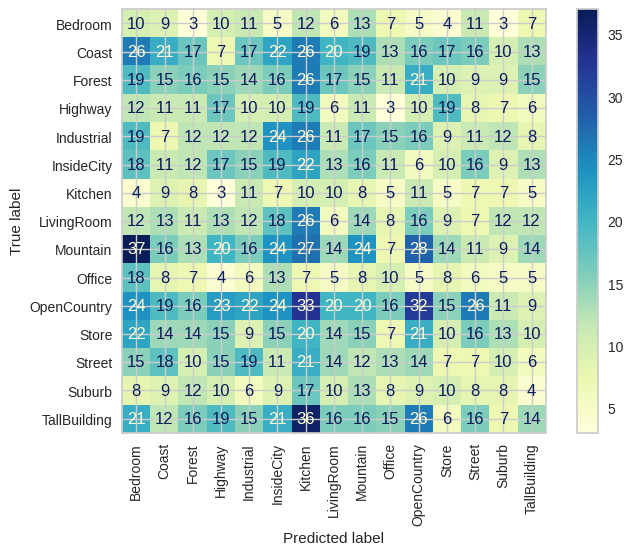

In [ ]:
predictions = label_encoder.inverse_transform(predictions)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predictions, display_labels=labels,xticks_rotation='vertical',cmap='YlGnBu')

#Facoltativo#

**Punto 6**
Optionally, you could train the SVM using a generalized Gaussian kernel
(Lecture 7) based on the χ^2 distance;

In [ ]:
def chi_square_kernel(x_i, x, eps=1e-10, A=1.0):
    """
    Computes the Chi-square kernel between two vectors x_i and x.
    """
    chi_square_dist = np.sum(((x_i - x)**2) / (x_i + x + eps))
    return np.exp(-chi_square_dist/A)

In [171]:
#training SVM
X_train = np.array(train_histograms)
K_train = np.array([[chi_square_kernel(x_i, x_j) for x_j in X_train] for x_i in X_train])

In [175]:
svm = SVC(kernel='precomputed')
classifiers_chi = []
#training di tutte e 15 le classi
for i in range(n_classes):
    svm.fit(K_train, y_train_bin[:,i])
    classifiers_chi.append(svm)

In [ ]:
predictions = []
for svm in classifiers_chi:
  support_vectors_indices = svm.support_
  support_vectors = X_train[support_vectors_indices]
  K_test = np.array([[chi_square_kernel(x_i, x_j) for x_j in X_test] for x_i in support_vectors])

In [ ]:
scores = np.array([clf.decision_function(X_test) for clf in classifiers]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)